In [2]:
import nltk
import torch
import pandas as pd
import numpy as np
from transformers import pipeline
from glob import glob
from nltk import sent_tokenize

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\28760\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load model


In [4]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

In [5]:
def load_model(device):
    theme_classfier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classfier

In [6]:
from transformers.utils import logging
logging.set_verbosity_info()

theme_classifier = load_model(device)

loading configuration file config.json from cache at C:\Users\28760\.cache\huggingface\hub\models--facebook--bart-large-mnli\snapshots\d7645e127eaf1aefc7862fd59a17a5aa8558b8ce\config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-large-mnli",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForSequenceClassification"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "contradiction",
    "1": "neutral",
    "2": "entailment

In [7]:
theme_list = ["friendship","hope","sacrifice","battle","self development","betrayal","love","dialogue"]

In [8]:
theme_classifier(
    "I gave him a right hook than a left jab",
    theme_list,
    multi_label=True
)

Disabling tokenizer parallelism, we're using DataLoader multithreading already


{'sequence': 'I gave him a right hook than a left jab',
 'labels': ['battle',
  'self development',
  'sacrifice',
  'betrayal',
  'hope',
  'dialogue',
  'friendship',
  'love'],
 'scores': [0.8533867597579956,
  0.3922497630119324,
  0.11604563146829605,
  0.057055845856666565,
  0.046761929988861084,
  0.01785803586244583,
  0.0017236076528206468,
  0.0010477514006197453]}

# Load Dataset


In [9]:
files = glob("../data/Subtitles/*.ass")

In [10]:
files[:5]

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [11]:
with open(files[0],'r',encoding='utf-8')as file:
    lines = file.readlines()
    lines = lines[27:]
    lines = [",".join(line.split(',')[9:]) for line in lines]
    

In [12]:
lines[:2]

['A long time ago, a powerful demon fox\\Nappeared with nine tails.\n',
 'With its powerful tails,\n']

In [13]:
lines = [line.replace('\\N',' ') for line in lines]

In [14]:
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [15]:
" ".join(lines[:10])

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n"

In [16]:
int(files[0].split('-')[-1].split('.')[0].strip())

1

In [17]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts=[]
    episode_num=[]

    for path in subtitles_paths:

        #Read Lines
        with open(path,'r',encoding='utf-8') as file:
            lines = file.readlines()
            lines = lines[27:]
            lines =  [ ",".join(line.split(',')[9:])  for line in lines ]
        
        lines = [ line.replace('\\N',' ') for line in lines]
        script = " ".join(lines)

        episode = int(path.split('-')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode":episode_num, "script":scripts })
    return df

In [18]:
dataset_path = "../data/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [19]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


# Run model


In [20]:
script = df.iloc[0]['script']

In [21]:
script

'A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can\'t let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known as… the Fourth Hokage.\n Naruto!\n Why did you do such a thing?!\n You\'re really gonna get it this time!\n I don\'t care!\n You know your problem?\n You can\'t do the things I do!\n Only I can do this!\n I\'m better than all of you! Believe it!\n There\'s a problem, sir!\n Lord Hokage!\n What is it?\n Did that Naruto do something again?\n Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them!\n Wait!\n Ha ha…\n Why should I?\n Hey, Naruto!\n How did you suddenly get here, lruka Sensei?\n The question is what are you doing here when you should 

In [22]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [23]:
# Batch Sentence
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)
    

In [24]:
script_batches[:2]

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [25]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [26]:
theme_output

[{'sequence': "A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
  'labels': ['dialogue',
   'betrayal',
   'battle',
   'sacrifice',
   'self development',
   'hope',
   'friendship',
   'love'],
  'scores': [0.980073869228363,
   0.9396896958351135,
   0.8546875715255737,
   0.7349797487258911,
   0.7284953594207764,
   0.1990982741117477

In [27]:
# Wrangle Output
# battle: [0.51489498, 0.2156498]
themes = {}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)
        

In [28]:
themes

{'dialogue': [0.980073869228363, 0.9370119571685791],
 'betrayal': [0.9396896958351135, 0.6457234621047974],
 'battle': [0.8546875715255737, 0.6581301689147949],
 'sacrifice': [0.7349797487258911, 0.6258823275566101],
 'self development': [0.7284953594207764, 0.867819607257843],
 'hope': [0.19909827411174774, 0.2042405754327774],
 'friendship': [0.05922313407063484, 0.08603332191705704],
 'love': [0.040261682122945786, 0.028020642697811127]}

In [29]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)
   # Batch Sentence
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    # Run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )
    # Writing output
    themes = {}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)
            
    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}
    return themes

In [30]:
themes

{'dialogue': [0.980073869228363, 0.9370119571685791],
 'betrayal': [0.9396896958351135, 0.6457234621047974],
 'battle': [0.8546875715255737, 0.6581301689147949],
 'sacrifice': [0.7349797487258911, 0.6258823275566101],
 'self development': [0.7284953594207764, 0.867819607257843],
 'hope': [0.19909827411174774, 0.2042405754327774],
 'friendship': [0.05922313407063484, 0.08603332191705704],
 'love': [0.040261682122945786, 0.028020642697811127]}

In [31]:
df = df.head(2)
df

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."


In [32]:
output_themes = df['script'].apply(get_themes_inference)
output_themes

0    {'dialogue': 0.9585429131984711, 'betrayal': 0...
1    {'dialogue': 0.9606050550937653, 'sacrifice': ...
Name: script, dtype: object

In [33]:
theme_df = pd.DataFrame(output_themes.tolist()) 
theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141
1,0.960605,0.429944,0.684845,0.570703,0.482807,0.154534,0.046261,0.173261


In [34]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960605,0.429944,0.684845,0.570703,0.482807,0.154534,0.046261,0.173261


# Visualize output

In [35]:
df = df.drop('dialogue',axis=1)

In [38]:
df

,episode,script,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.792707,0.756409,0.680431,0.798157,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.429944,0.684845,0.570703,0.482807,0.154534,0.046261,0.173261


In [41]:
df = df.drop('dialogue',axis=1)

KeyError: "['dialogue'] not found in axis"

In [43]:
print(df.columns.tolist())

['episode', 'script', 'betrayal', 'battle', 'sacrifice', 'self development', 'hope', 'friendship', 'love']


In [49]:
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,betrayal,1.222650
1,battle,1.441254
2,sacrifice,1.251134
3,self development,1.280964
4,hope,0.356203
5,friendship,0.118889
6,love,0.207403


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns 

<function matplotlib.pyplot.show(close=None, block=None)>

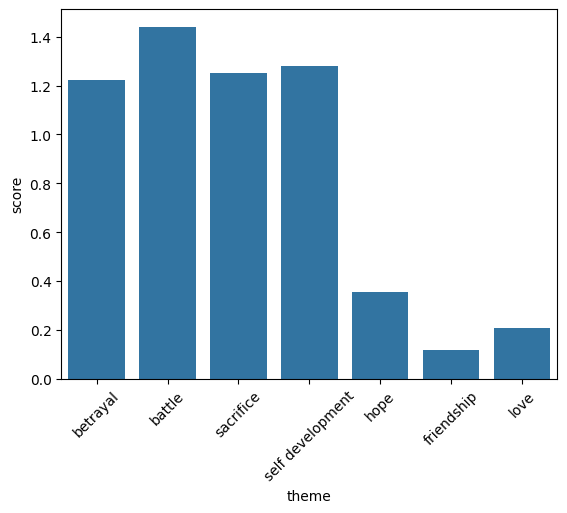

In [53]:
sns.barplot(data = theme_output, x="theme",y="score")
plt.xticks(rotation = 45)
plt.show